<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINNs_wave_eq_experimentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.devitoproject.org/devito/index.html

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import libraries and tools
import numpy as np
rng = np.random.default_rng()

from time import perf_counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

from examples.seismic import Model, plot_velocity
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Cloning into 'MScDataSci_21-22'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 370 (delta 110), reused 29 (delta 17), pack-reused 188
Receiving objects: 100% (370/370), 12.23 MiB | 18.52 MiB/s, done.
Resolving deltas: 100% (225/225), done.


device(type='cpu')

## General definition

In [3]:
xLimit_m = 1.e3 ### METRES ###
zLimit_m = 1.e3 ### METRES ###
tLimit_s = 1. ### SECONDS ###

## Devito

In [4]:
nx = 200 ### NODES ###
nz = 200 ### NODES ###

absorbingLayer = 10 ### NODES ###

dx = xLimit_m / (nx-1) ### METRES ###
dz = zLimit_m / (nz-1) ### METRES ###

origin = (0., 0.)
spacing = (dz, dx)
shape = (nz, nx)

v = np.ones(shape, dtype=np.float32)

devitoModel = Model(vp=v,
                    origin=origin,
                    shape=shape,
                    spacing=spacing,
                    space_order=2,
                    nbl=absorbingLayer,
                    bcs='damp',
                    )

dt = devitoModel.critical_dt
tLimit_ms = tLimit_s * 1e3 ### MILLISECONDS ###
nt = tLimit_ms / dt
timeRange = TimeAxis(start=0, stop=tLimit_ms, step=dt)

u = TimeFunction(name='u',
                 grid=devitoModel.grid,
                 time_order=2,
                 space_order=2,
                 save=int(nt)+2,
                 )

pde = devitoModel.m * u.dt2 - u.laplace + devitoModel.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

f0 = 0.01 ### kHZ ###
source = RickerSource(name='src',
                      grid=devitoModel.grid,
                      f0=f0,
                      npoint=1,
                      time_range=timeRange,
                      )

source.coordinates.data[0, 0] = int(zLimit_m*0.5) ### METRES ###
source.coordinates.data[0, 1] = int(xLimit_m*0.5) ### METRES ###

sourceTerm = source.inject(field=u.forward, expr=source * dt**2 / devitoModel.m)

op = Operator([stencil] + sourceTerm, subs=devitoModel.spacing_map)

Operator `initdamp` ran in 0.01 s
INFO:Devito:Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO:Devito:Operator `pad_vp` ran in 0.01 s


# Define medium

In [5]:
# define medium (acoustic wavespeed)

# v[:, :] = 1. ### KM/S ###
# v[:, int(shape[1]/2):] = 1.5  ### KM/S ###

In [6]:
# log start time to measure performance
startTime = perf_counter()

# generate solution
summary = op.apply(time=int(nt), dt=dt)

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

FD_solution = u.data[:,
                     absorbingLayer:u.data.shape[1]-absorbingLayer,
                     absorbingLayer:u.data.shape[2]-absorbingLayer
                     ].copy()
FD_solution.shape

Operator `Kernel` ran in 0.05 s
INFO:Devito:Operator `Kernel` ran in 0.05 s


Training duration: 0.86s


(326, 200, 200)

In [7]:
xRange = np.arange(0, nx*dx, dx)
zRange = np.arange(0, nz*dz, dz)

xGrid, zGrid = np.meshgrid(xRange, zRange)

In [9]:
numPlots = 5



# create normaliser for colorbar
plotData = np.empty(0)
for num in range(numPlots):
    plotData = np.append(plotData, np.array(uInterior[num*int(uInterior.shape[0]/numPlots)]))
norm = matplotlib.colors.Normalize(plotData.min(), plotData.max())

cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axs = plt.subplots(1, numPlots,
                        figsize=(24, 4),
                        constrained_layout=True,
                        sharey=True,
                        )
axs[0].invert_yaxis()

for idx, ax in enumerate(axs):
    # print(idx*int(u.data.shape[0]/numPlots) * (T / u.data.shape[0]))
    plot = ax.pcolormesh(x, z, uInterior[(idx+1)*int(uInterior.shape[0]/numPlots)], norm=norm, cmap='bwr')
    ax.set_title(f'Time: {1e-3 * (idx+1)*int(uInterior.shape[0]/numPlots) * (T / uInterior.shape[0]):.2f}s')

fig.colorbar(mapping, aspect=60)

plt.show()

NameError: ignored

# PINN

PDE loss term is 20,000 points  
while 3,600 points are set for each of the early-time snapshot data

NsxArray consists of Nsx randomly sampled points from time sx (t, x, z, u)

In [19]:
# define physics informed neural network for 1D Burgers' equation
class PINN_2D_AcousticWave(torch.nn.Module):
    def __init__(self,
                 hiddenLayers,
                 nodesPerLayer,
                 activationFunction,
                 uTrain,
                 uTrainDeltas,
                 maxArray,
                 NuTotal,
                 NfTotal,
                 trainingResample,
                 NuRange,

                #  xRange,
                #  zRange,
                #  xGrid,
                #  zGrid,
                 maxIterations,
                 maxEvaluations,
                 l1,
                 l2,
                 verbose = True
                 ):
        super(PINN_2D_AcousticWave, self).__init__()
        # network structure
        self.layers = torch.nn.ModuleList()
        self.activationFunction = activationFunction
        # input layer
        self.layers.append(torch.nn.Linear(3, nodesPerLayer))
        # hidden layers
        for _ in range(hiddenLayers):
            self.layers.append(torch.nn.Linear(nodesPerLayer, nodesPerLayer))
        # output layer
        self.layers.append(torch.nn.Linear(nodesPerLayer, 1))

        self.uTrain = uTrain
        self.uTrainDeltas = uTrainDeltas

        self.maxArray = maxArray
        self.maxArray[-1] = uTrain.max()
        
        self.NuTotal = NuTotal
        self.NfTotal = NfTotal

        self.trainingResample = trainingResample
        self.NuRange = NuRange

        self.l1 = l1
        self.l2 = l2

        self.history = np.empty((0,3), float)        

        # boolean whether to print update during training
        self.verbose = verbose

        self.AdamOptimiser = torch.optim.Adam(
            self.parameters(),
            # lr=1.e-5,
            )

        # define L-BFGS optimiser
        self.LBFGS_optimiser = torch.optim.LBFGS(
            self.parameters(),
            # max_iter=maxIterations,
            # max_eval=maxEvaluations,
            # tolerance_change= 1.0 * np.finfo(float).eps,
            line_search_fn='strong_wolfe',
            )

    def createNf(self, tLim):
        # create collocation training points selected uniformly randomly across input domain: t - x - z
        Nf = np.array([
            rng.uniform(0, tLim, self.NfTotal),
            rng.uniform(0, self.maxArray[1], self.NfTotal),
            rng.uniform(0, self.maxArray[2], self.NfTotal),
            ]).T

        Nf /= self.maxArray[:-1]

        return torch.from_numpy(Nf.astype(np.float32)).requires_grad_().to(device)

    def createNu(self):
        if self.NuRange:
            Nu = np.array([
                rng.choice(self.uTrain.shape[0], self.NuTotal, replace=True),
                rng.choice(self.uTrain.shape[2], self.NuTotal, replace=True),
                rng.choice(self.uTrain.shape[1], self.NuTotal, replace=True),
                np.zeros(self.NuTotal)
                ]).astype(float).T
            Nu[:,3] = self.uTrain[
                Nu[:,0].astype(int),
                Nu[:,1].astype(int),
                Nu[:,2].astype(int)]
            Nu[:,:3] *= self.uTrainDeltas
        else:
            N = int(self.NuTotal*0.5)
            Nu1 = np.array([
                        np.zeros(N),
                        rng.choice(self.uTrain.shape[2], N, replace=True),
                        rng.choice(self.uTrain.shape[1], N, replace=True),
                        np.zeros(N),
                     ]).astype(float).T
            Nu1[:,3] = self.uTrain[0][
                            Nu1[:,1].astype(int),
                            Nu1[:,2].astype(int)]
            Nu1[:,:3] *= self.uTrainDeltas
            Nu2 = np.array([
                        np.ones(N) * self.uTrain.shape[0],
                        rng.choice(self.uTrain.shape[2], N, replace=True),
                        rng.choice(self.uTrain.shape[1], N, replace=True),
                        np.zeros(N),
                     ]).astype(float).T
            Nu2[:,3] = self.uTrain[-1][
                                Nu2[:,1].astype(int),
                                Nu2[:,2].astype(int)]
            Nu2[:,:3] *= self.uTrainDeltas
            Nu = np.concatenate([Nu1, Nu2])

        Nu /= self.maxArray

        return torch.from_numpy(Nu[:,:-1].astype(np.float32)).requires_grad_().to(device),\
         torch.from_numpy(Nu[:,-1].astype(np.float32).reshape(Nu.shape[0],1)).to(device)

    # compute solution via forward pass
    def forward(self, X):
        input = X
        for layer in self.layers[:-1]:
            input = self.activationFunction(layer(input))
        return self.layers[-1](input)

    # compute PDE residual
    def residual(self, X):
        t = X[:,0]
        x = X[:,1]
        z = X[:,2]
        X = torch.stack((t,x,z)).T
        # compute solution
        u = self.forward(X).flatten()

        du_dNf = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        d2u_dt2 = torch.autograd.grad(du_dNf[:,0], t, torch.ones_like(u), create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dNf[:,1], x, torch.ones_like(u), create_graph=True)[0]
        d2u_dz2 = torch.autograd.grad(du_dNf[:,2], z, torch.ones_like(u), create_graph=True)[0]

        m = 1.
        # compute PDE residual
        return d2u_dt2 - (d2u_dx2 + d2u_dz2) #m**2 * 

    def lossFunc(self, Nu_pred, Nu_targ, Nf_r):
        self.iterationCount += 1
        # compute constituent loss components
        NuLoss = torch.mean(torch.square(Nu_pred - Nu_targ))
        if Nf_r != None:
            NfLoss = torch.mean(torch.square(Nf_r))
        else:
            NfLoss = torch.tensor([0.]).to(device)
        totalLoss = self.l1*NfLoss + self.l2*NuLoss
        # store losses
        self.history = np.append(self.history,
                                 np.array([
                                           [totalLoss.item()],
                                           [NuLoss.item()],
                                           [NfLoss.item()],
                                           ]).T,
                                 axis=0)
        # print training progress update (every (2**2)th epoch initially, then every 500th)
        if self.verbose and ((np.log2(self.iterationCount) % 1 == 0 and self.iterationCount < 500) or self.iterationCount % 500 == 0):
            seconds = perf_counter() - self.startTime
            print(f'Epoch: {self.iterationCount} --- Elapsed time: {int(seconds/60)}m{int(seconds%60)}s --- Loss: {self.history[-1,0]}')
        return totalLoss

    def Adam_trainer(self, epochs):#, curricEpochs):

        self.train()
    
        self.iterationCount = 0
        self.startTime = perf_counter()

        tLim = self.maxArray[0]

        Nf = self.createNf(tLim)
        Nu, Nu_targ = self.createNu()

        for _ in range(epochs):
            self.AdamOptimiser.zero_grad()

            Nu_pred = self.forward(Nu)
            Nf_r = self.residual(Nf)
            lossValue = self.lossFunc(Nu_pred, Nu_targ, Nf_r)

            lossValue.backward()
            self.AdamOptimiser.step()

            if self.trainingResample:
                Nf = self.createNf(tLim)
                Nu, Nu_targ = self.createNu()

        self.eval()
    
    def LBFGS_trainer(self, NuArray, NfArray):
        # set to train mode
        self.train()
        # initialise variables to track progress
        self.iterationCount = 0
        self.startTime = perf_counter()
        # Prepare training tensors
        Ns1Tens = torch.from_numpy(Ns1Array[:,:-1].astype(np.float32)).requires_grad_().to(device)
        Ns1_d = torch.from_numpy(Ns1Array[:,-1].astype(np.float32).reshape(Ns1Array.shape[0],1)).to(device)

        Ns2Tens = torch.from_numpy(Ns2Array[:,:-1].astype(np.float32)).requires_grad_().to(device)
        Ns2_d = torch.from_numpy(Ns2Array[:,-1].astype(np.float32).reshape(Ns2Array.shape[0],1)).to(device)

        NfTens = torch.from_numpy(NfArray.astype(np.float32)).requires_grad_().to(device)

        # define closure function for L-BFGS optimiser
        def closure():
            self.LBFGS_optimiser.zero_grad()
            Ns1_u = self.forward(Ns1Tens)
            Ns2_u = self.forward(Ns2Tens)
            Nf_r = self.residual(NfTens)
            lossValue = self.lossFunc(Ns1_u, Ns1_d, Ns2_u, Ns2_d, Nf_r)
            lossValue.backward()
            return lossValue
        # run optimiser
        self.LBFGS_optimiser.step(closure)
        # training complete, set to evaluation mode
        self.eval()

    # def medium(self, x, z):
        
    #     return (1. * torch.ones(x.shape[0])).to(device)# + (z > 500) * 1.
        # return 1.e3 * torch.ones(x.shape[0]) # + (y > 500) * 1.e3

In [23]:
# define network characteristics
hiddenLayers = 4
nodesPerLayer = 20
activationFunction = nn.Softplus()

sourceEndTime = 2/f0 ### MILLISECONDS ###
fdSliceStart = int(sourceEndTime/dt)
fdSliceEnd = fdSliceStart + 10
uTrain = FD_solution[fdSliceStart:fdSliceEnd]

uTrainDeltas = np.array([
    dt*1e-3,
    dx,
    dz,])
maxArray = np.array([
    (tLimit_ms - sourceEndTime) * 1e-3,
    xLimit_m,
    zLimit_m,
    0.,])

NuTotal = 100
NfTotal = 100
trainingResample = False
NuRange = False

maxIterations = 50000
maxEvaluations = 50000
l1 = 0.1 # residual (PDE)
l2 = 1. # snapshots

model = PINN_2D_AcousticWave(hiddenLayers, nodesPerLayer, activationFunction,
                             uTrain, uTrainDeltas, maxArray,
                             NuTotal, NfTotal,
                             trainingResample, NuRange,
                             maxIterations, maxEvaluations,
                             l1, l2)
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

model = model.to(device)

Network parameters: 1781


In [24]:
model.Adam_trainer(1000)

Epoch: 1 --- Elapsed time: 0m0s --- Loss: 0.42908981442451477
Epoch: 2 --- Elapsed time: 0m0s --- Loss: 0.3876546025276184
Epoch: 4 --- Elapsed time: 0m0s --- Loss: 0.2772595286369324
Epoch: 8 --- Elapsed time: 0m0s --- Loss: 0.1813075989484787
Epoch: 16 --- Elapsed time: 0m0s --- Loss: 0.04100550338625908
Epoch: 32 --- Elapsed time: 0m0s --- Loss: 0.03676750510931015
Epoch: 64 --- Elapsed time: 0m1s --- Loss: 0.016714900732040405
Epoch: 128 --- Elapsed time: 0m3s --- Loss: 0.03384040668606758
Epoch: 256 --- Elapsed time: 0m6s --- Loss: 0.03276782110333443
Epoch: 500 --- Elapsed time: 0m12s --- Loss: 0.005587838590145111
Epoch: 1000 --- Elapsed time: 0m24s --- Loss: 0.017469387501478195


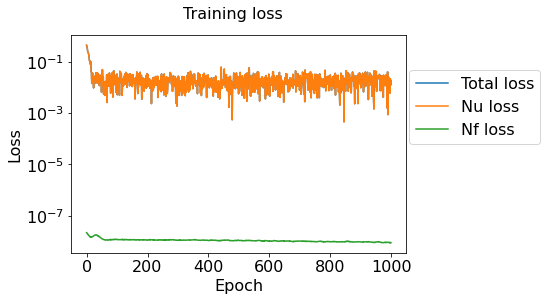

In [25]:
fig = utilityFunctions.trainingHistoryPlot(model.history,
                                           ['Total loss', 'Nu loss', 'Nf loss'],
                                           'Loss',
                                           'Training loss',
                                           yLogAx=True,
                                           )

## Plots
Compute u from PINN for all t, x, z in same results form as Devito (np array: t-z-x)

In [ ]:
numPlots = 5
# t = np.arange(0.012, 0.030, 0.003)
tPlot = 1000*1.e-3

t = np.arange(0, tPlot+tPlot/numPlots, tPlot/numPlots)

x = np.arange(0, nx*dx, dx)
z = np.arange(0, nz*dz, dz)

# x = np.arange(0, extent_x+500., 500.)
# z = np.arange(0, extent_z+500., 500.)

xArray, tArray, zArray = np.meshgrid(x, t, z)
NArray = np.stack((tArray.flatten(), xArray.flatten(), zArray.flatten())).T

uTensFlat = model(torch.from_numpy((2*NArray/maxArray[:-1] - 1).astype(np.float32)).to(device))
uArray = np.reshape(uTensFlat.cpu().detach().numpy(), (numPlots+1, nz, nx))

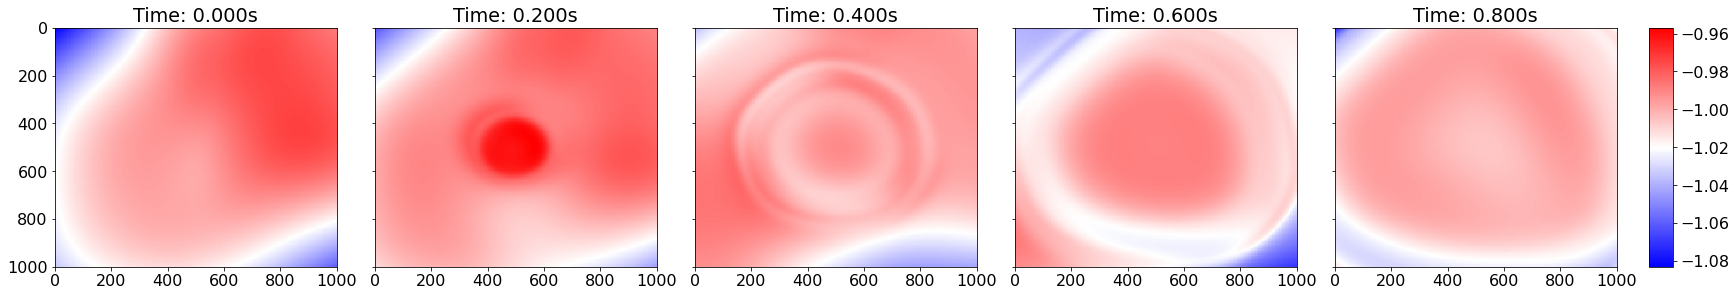

In [ ]:
norm = matplotlib.colors.Normalize(uArray.min(), uArray.max())

cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axs = plt.subplots(1, numPlots,
                        figsize=(24, 4),
                        constrained_layout=True,
                        sharey=True,
                        )
axs[0].invert_yaxis()

for idx, ax in enumerate(axs):
    # print(idx*int(u.data.shape[0]/numPlots) * (T / u.data.shape[0]))
    plot = ax.pcolormesh(x, z, uArray[idx], norm=norm, cmap='bwr')
    ax.set_title(f'Time: {t[idx]:.3f}s')

fig.colorbar(mapping, aspect=60)

plt.show()

In [ ]:
print(f'{(dt*s1/1000):.2f}')
print(f'{(dt*s2/1000):.2f}')

0.24
0.37


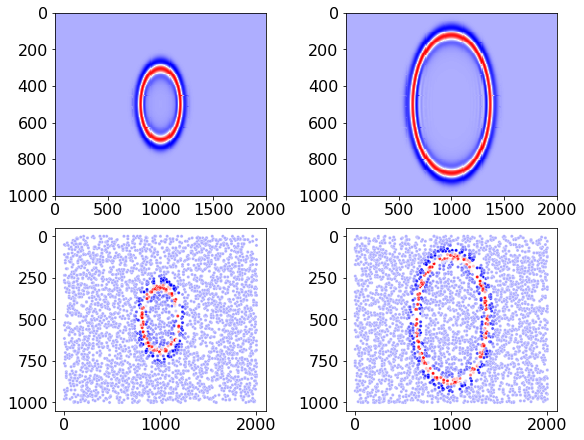

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True,)

ax1.pcolormesh(x, z, uInterior[s1], cmap='bwr')
ax1.invert_yaxis()
ax2.pcolormesh(x, z, uInterior[s2], cmap='bwr')
ax2.invert_yaxis()

sns.scatterplot(
    ax=ax3,
    x=Ns1Array[:,1],
    y=Ns1Array[:,2],
    hue=Ns1Array[:,3],
    palette='bwr',
    s=10,
    legend = False
    )
ax3.invert_yaxis()

sns.scatterplot(
    ax=ax4,
    x=Ns2Array[:,1],
    y=Ns2Array[:,2],
    hue=Ns2Array[:,3],
    palette='bwr',
    s=10,
    legend = False
    )
ax4.invert_yaxis()

plt.show()